<h2>Gradient Boosting Machine: GBM

![image.png](attachment:image.png)

![image.png](attachment:image.png)

<h4> 1) 결정한 tree수까지 tree를 계속 나눠보기
 - ex) tree=160이면 160번 잘릴 때까지 error를 끝까지 구하는 것

In [271]:
import numpy as np
from sklearn.metrics import mean_squared_error
import time
import matplotlib.pyplot as plt

class gbm:
	def __init__(self, x, y, x_split_val=0.1, tree=3):
		self.x = x
		self.y = y
		self.x_split_val = x_split_val
		self.tree = tree

        
    # xmin과 xmax를 구해서 그 사이 구간을 x_split_val만큼 증가시켜서 splited_x 리스트에 저장하는 함수
    # 이 리스트가 x_threshold로 사용됨
	def split_x(self, x, x_split_val):
		x_sort = np.sort(x, axis=0)
		xmin, xmax = x_sort[0], x_sort[-1]
		splited_x = []
		while xmin < xmax :
			splited_x.append(xmin)
			xmin = xmin + x_split_val
		return splited_x

    
    # x_threshold 값을 기준으로 나눌 때, 각 x와 y의 값을 리스트로 반환하는 함수
	def split(self, x, y, x_threshold):
		indices_left = [i for i, x_i in enumerate(x) if x_i <= x_threshold]
		indices_right = [i for i, x_i in enumerate(x) if x_i > x_threshold]

		x_left = np.array([x[i] for i in indices_left])
		y_left = np.array([y[i] for i in indices_left])
		x_right = np.array([x[i] for i in indices_right])
		y_right = np.array([y[i] for i in indices_right])
		return x_left, y_left, x_right, y_right
		"""
x_left, y_left, x_right, y_right: [[ 1.]] [ 2.2] [[ 1.8]
 [ 3. ]
 [ 3.7]
 [ 4. ]
 [ 4.2]
 [ 4.5]
 [ 5. ]
 [ 5.3]
 [ 5.4]
 [ 5.9]
 [ 6.8]
 [ 7. ]
 [ 7.5]
 [ 7.6]
 [ 7.7]
 [ 8.1]
 [ 8.3]
 [ 9. ]
 [ 9.5]] [ 0.7  0.6  0.9  1.   1.4  1.5  0.8 -0.7 -0.8 -0.9  0.4  0.6 -0.7 -1.  -1.2
 -1.5  1.6 -1.1  0.9]
 		"""
    
    # split함수에서 받은 x_left, y_left, x_right, y_right로
    # x를 기준으로 나뉜 x의 왼쪽과 x의 오른쪽에 존재하는 y값의 평균을 구하고,
    # 그 평균을 기존의 y에서 빼서 각각의 잔차(residual)를 구한다. 
    # --> (매번 tree를 만들기 위해서) 최적의 y split값을 찾기 위한 리스트들을 만든다고 보면 됨.
	def split_y(self, x, y):
		x_thresholds = self.split_x(x, self.x_split_val)
		y_list, left_list, right_list = [], [], []
		for j in range(len(x_thresholds)):
			x_left, y_left, x_right, y_right = self.split(x, y, x_thresholds[j])
# 			print("x_left, y_left, x_right, y_right:",x_left, y_left, x_right, y_right)
			split_y_left = np.mean(y_left)
			y_left_residual = y_left - split_y_left
			left_list.append(split_y_left)

			split_y_right = np.mean(y_right)
			y_right_residual = y_right - split_y_right
			right_list.append(split_y_right)

			y_list.append(np.append(y_left_residual, y_right_residual))
		return y_list, x_thresholds, left_list, right_list


    
	# squared loss 함수를 이용해서 가장 최적의 new_y를 찾아가면서 tree를 구축할 수 있는
    # 각각의 new_x_list, new_y_list, split_y_left_list, split_y_right_list, beststump, error을 반환하기 위한 함수
	def select_residual(self):
		new_x = None
		new_y = self.y
		l_ = None
		r_ = None
		error = np.inf
		new_x_list, new_y_list, split_y_left_list, split_y_right_list = [], [], [], []
		beststump = {}

		for s in range(self.tree):
			selected_y_list, x_thresholds, left_list, right_list = self.split_y(self.x, new_y)
			
			new_x_list.append(new_x)
			new_y_list.append(new_y)

			split_y_left_list.append(l_)
			split_y_right_list.append(r_)
			q_list = []
            
			for u in range(len(selected_y_list)):
				q = selected_y_list[u]
				q_list.append(self.squared_loss(q))
				min_error = min(q_list)
				new_y = selected_y_list[q_list.index(min(q_list))]
				new_x = x_thresholds[q_list.index(min(q_list))]
				l_ = left_list[q_list.index(min(q_list))]
				r_ = right_list[q_list.index(min(q_list))]
				if min_error < error:
					error = min_error
					beststump['s'] = s
		return new_x_list, new_y_list, split_y_left_list, split_y_right_list, beststump, error

    
	#loss function for regression - squared loss
	def squared_loss(self, selected_list):
		return sum( 0.5 *((selected_list) ** 2) )

    
	# select_residual함수에서 얻은 최적의 x, x 기준 왼쪽 y, 오른쪽 y의 최적값을 가지고,
    # testdata가 들어왔을 때, y를 예측하는 함수
	def predict(self, testdata):
		new_x_list, new_y_list, split_y_left_list, split_y_right_list, beststump, error = self.select_residual()

		predicted_val_list = []
		for m in range(len(testdata)):
			residual_sum = []
			for n in range(len(split_y_left_list)-1):
				if testdata[m] <= new_x_list[n+1]:
					residual_sum.append(split_y_left_list[n+1])
				else:
					residual_sum.append(split_y_right_list[n+1])
			print(testdata[m], "predict value: ", sum(residual_sum))
			predicted_val_list.append(sum(residual_sum))
		return predicted_val_list

    
#사용한 데이터
def loadSimpleData():
	train_data = np.array([[1], [1.8], [3], [3.7], [4], [4.2], [4.5], [5], [5.3], [5.4], [5.9], [6.8], [7], [7.5], [7.6], [7.7],
	                 [8.1], [8.3], [9], [9.5]])
	train_label = np.array([2.2, 0.7, 0.6, 0.9, 1, 1.4, 1.5, 0.8, -0.7, -0.8, -0.9, 0.4, 0.6, -0.7, -1.0, -1.2, -1.5, 1.6, -1.1, 0.9])
	# train_data = np.array([[1], [1.8], [3], [3.7], [4], [4.2], [4.5], [5], [5.3], [5.4]])
	# train_label = np.array([2.2, 0.7, 0.6, 0.9, 1, 1.4, 1.5, 0.8, -0.7, -0.8])
	test_data = np.array([[1], [3], [3.7], [4.2], [4.5]])
	test_label = [2.2, 0.6, 1, 1.4, 1.5]
	return train_data, train_label, test_data, test_label

train_data, train_label, test_data, test_label = loadSimpleData()

start gbm...
[ 1.] predict value:  2.19879837966
[ 3.] predict value:  0.608453612267
[ 3.7] predict value:  0.898959790869
[ 4.2] predict value:  1.40280686442
[ 4.5] predict value:  1.48462444339
test_label:  [2.2, 0.6, 1, 1.4, 1.5]
predicted_label:  [2.1987983796599662, 0.60845361226710359, 0.89895979086892064, 1.4028068644174896, 1.4846244433908051]
MSE: 0.0021
time:  2.335663318634033


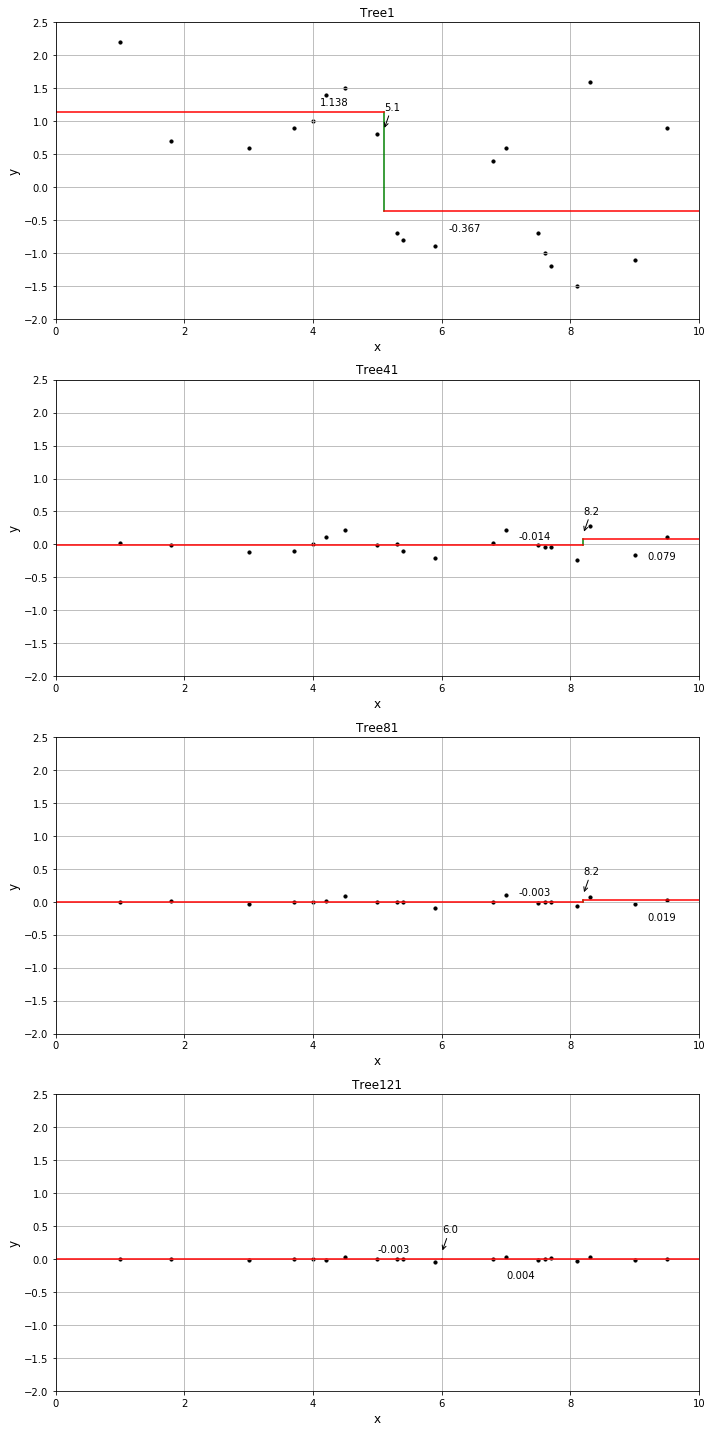

In [272]:
# tree = 160
if __name__ == '__main__':
	start = time.time()
	print("start gbm...")
	GBM = gbm(x=train_data, y=train_label, x_split_val=0.1, tree=160) # x값은 0.1씩 움직이면서 160개 tree를 만들어보자!
	new_x_list, new_y_list, split_y_left_list, split_y_right_list, beststump, error = GBM.select_residual()
# 	print("best_tree: ", beststump.get('s'))
	predicted_label = GBM.predict(testdata=test_data) # testdata를 넣어서 예측해보자!
	print("test_label: ", test_label) # 실제 테스트 데이터의 y값
	print("predicted_label: ", predicted_label) # 예측된 값

	mse = mean_squared_error(test_label, predicted_label) # mse값
	print("MSE: %.4f" % mse)
	end = time.time()
	print("time: ", end-start)

    ### ##### plot ####### ###
	i = 1
	plt.figure(figsize=(10, 20))
	for e in range(1, 160, 40): #160까지 돌렸을 때, 40번째 tree마다 그래프로 확인해보자!
		plt.subplot(410 + i)

		plt.scatter(train_data, new_y_list[e - 1], s=10, c='black')

		x_split_val = new_x_list[e][0]
		y_left_val = split_y_left_list[e]
		y_right_val = split_y_right_list[e]

		plt.plot([x_split_val,x_split_val],[y_left_val,y_right_val], color='green')
		plt.plot([0, x_split_val], [y_left_val, y_left_val], color='red')
		plt.plot([x_split_val, 10], [y_right_val, y_right_val], color='red')
		plt.grid(True)

		plt.xlim(0, 10)
		plt.ylim(-2.0, 2.5)
		plt.xlabel("x", fontsize=12)
		plt.ylabel("y", fontsize=12)
		plt.annotate(str(round(x_split_val, 3)), xy=(x_split_val, (y_left_val+y_right_val)+0.1),
		             xytext=(x_split_val, (y_left_val+y_right_val)+0.4), arrowprops=dict(arrowstyle="->"), fontsize=10)
		plt.annotate(str(round(y_left_val, 3)), xy=(x_split_val-1, y_left_val+0.5),
		             xytext=(x_split_val-1, y_left_val+0.1), fontsize=10)
		plt.annotate(str(round(y_right_val, 3)), xy=(x_split_val+1, y_right_val-0.5),
		             xytext=(x_split_val+1, y_right_val-0.3), fontsize=10)
		plt.title("Tree"+str(e))
		plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

		i = i + 1
	plt.tight_layout()
	plt.show()

In [254]:
new_x_list[0:5]

[None, array([ 5.1]), array([ 8.2]), array([ 1.]), array([ 7.1])]

In [255]:
new_y_list[0:5]

[array([ 2.2,  0.7,  0.6,  0.9,  1. ,  1.4,  1.5,  0.8, -0.7, -0.8, -0.9,
         0.4,  0.6, -0.7, -1. , -1.2, -1.5,  1.6, -1.1,  0.9]),
 array([ 1.0625    , -0.4375    , -0.5375    , -0.2375    , -0.1375    ,
         0.2625    ,  0.3625    , -0.3375    , -0.33333333, -0.43333333,
        -0.53333333,  0.76666667,  0.96666667, -0.33333333, -0.63333333,
        -0.83333333, -1.13333333,  1.96666667, -0.73333333,  1.26666667]),
 array([ 1.20955882, -0.29044118, -0.39044118, -0.09044118,  0.00955882,
         0.40955882,  0.50955882, -0.19044118, -0.18627451, -0.28627451,
        -0.38627451,  0.91372549,  1.11372549, -0.18627451, -0.48627451,
        -0.68627451, -0.98627451,  1.13333333, -1.56666667,  0.43333333]),
 array([ 0.        , -0.22678019, -0.32678019, -0.02678019,  0.07321981,
         0.47321981,  0.57321981, -0.12678019, -0.12261352, -0.22261352,
        -0.32261352,  0.97738648,  1.17738648, -0.12261352, -0.42261352,
        -0.62261352, -0.92261352,  1.19699432, -1.50300

In [256]:
split_y_left_list[0:5]

[None, 1.1375, -0.14705882352941171, 1.2095588235294119, 0.14611316186393586]

In [257]:
split_y_right_list[0:5]

[None,
 -0.3666666666666667,
 0.83333333333333337,
 -0.063660990712074345,
 -0.27135301489016661]

In [260]:
error

0.00073233728926643926

<h4>2) error를 변경하면서 gbm돌려보기
 - ex) tree=160이고, error=0.1, 0.01, 0.001로 바꿔가면서 돌려보기

In [261]:
import numpy as np
from sklearn.metrics import mean_squared_error
import time
import matplotlib.pyplot as plt

class gbm:
	def __init__(self, x, y, x_split_val=0.1, tree=160, error=0.1):
		self.x = x
		self.y = y
		self.x_split_val = x_split_val
		self.tree = tree
		self.error = error #앞 코드에서 추가된 부분

	def split_x(self, x, x_split_val):
		x_sort = np.sort(x, axis=0)
		xmin, xmax = x_sort[0], x_sort[-1]
		splited_x = []
		while xmin < xmax :
			splited_x.append(xmin)
			xmin = xmin + x_split_val
		return splited_x


	def split(self, x, y, x_threshold):
		indices_left = [i for i, x_i in enumerate(x) if x_i <= x_threshold]
		indices_right = [i for i, x_i in enumerate(x) if x_i > x_threshold]

		x_left = np.array([x[i] for i in indices_left])
		y_left = np.array([y[i] for i in indices_left])
		x_right = np.array([x[i] for i in indices_right])
		y_right = np.array([y[i] for i in indices_right])
		return x_left, y_left, x_right, y_right


	def split_y(self, x, y):
		x_thresholds = self.split_x(x, self.x_split_val)
		y_list, left_list, right_list = [], [], []
		for j in range(len(x_thresholds)):
			x_left, y_left, x_right, y_right = self.split(x, y, x_thresholds[j])
			split_y_left = np.mean(y_left)
			y_left_residual = y_left - split_y_left
			left_list.append(split_y_left)

			split_y_right = np.mean(y_right)
			y_right_residual = y_right - split_y_right
			right_list.append(split_y_right)
			y_list.append(np.append(y_left_residual, y_right_residual))
		return y_list, x_thresholds, left_list, right_list


	def select_residual(self):
		new_x = None
		new_y = self.y
		l_ = None
		r_ = None
		min_error = np.inf
		new_x_list, new_y_list, split_y_left_list, split_y_right_list = [], [], [], []
		beststump = {}

		for s in range(self.tree):
			selected_y_list, x_thresholds, left_list, right_list = self.split_y(self.x, new_y)

			new_x_list.append(new_x)
			new_y_list.append(new_y)

			split_y_left_list.append(l_)
			split_y_right_list.append(r_)
            
			q_list = []
			for u in range(len(selected_y_list)):
				q = selected_y_list[u]
				q_list.append(0.5*sum(q**2))
				min_error = min(q_list)
				new_y = selected_y_list[q_list.index(min(q_list))]
				new_x = x_thresholds[q_list.index(min(q_list))]
				l_ = left_list[q_list.index(min(q_list))]
				r_ = right_list[q_list.index(min(q_list))]
        ### 앞 코드와 다른 부분 ###
			if (min_error < self.error):
				beststump['s'] = s
				break
			else:
				continue
        ### ################## ###
		return new_x_list, new_y_list, split_y_left_list, split_y_right_list, beststump, min_error


	def predict(self, testdata):
		new_x_list, new_y_list, split_y_left_list, split_y_right_list, beststump, min_error = self.select_residual()

		predicted_val_list = []
		for m in range(len(testdata)):
			residual_sum = []
			for n in range(len(split_y_left_list)-1):
				if testdata[m] <= new_x_list[n+1]:
					residual_sum.append(split_y_left_list[n+1])
				else:
					residual_sum.append(split_y_right_list[n+1])
			print(testdata[m], "predict value :", sum(residual_sum))
			predicted_val_list.append(sum(residual_sum))
		return predicted_val_list


def loadSimpleData():
	train_data = np.array([[1], [1.8], [3], [3.7], [4], [4.2], [4.5], [5], [5.3], [5.4], [5.9], [6.8], [7], [7.5], [7.6], [7.7],
	                 [8.1], [8.3], [9], [9.5]])
	train_label = np.array([2.2, 0.7, 0.6, 0.9, 1, 1.4, 1.5, 0.8, -0.7, -0.8, -0.9, 0.4, 0.6, -0.7, -1.0, -1.2, -1.5, 1.6, -1.1, 0.9])
	# train_data = np.array([[1], [1.8], [3], [3.7], [4], [4.2], [4.5], [5], [5.3], [5.4]])
	# train_label = np.array([2.2, 0.7, 0.6, 0.9, 1, 1.4, 1.5, 0.8, -0.7, -0.8])
	test_data = np.array([[1], [3], [3.7], [4.2], [4.5]])
	test_label = [2.2, 0.6, 1, 1.4, 1.5]
	return train_data, train_label, test_data, test_label

train_data, train_label, test_data, test_label = loadSimpleData()

In [262]:
if __name__ == '__main__':
	start = time.time()
	print("start gbm...")
	GBM = gbm(x=train_data, y=train_label, x_split_val=0.1, tree=160, error=0.1) #앞 코드와 달리 error값 추가 - error:0.1
	new_x_list, new_y_list, split_y_left_list, split_y_right_list, beststump, min_error = GBM.select_residual()
	print("best_tree:", beststump.get('s'))

	predicted_label = GBM.predict(testdata=test_data)
	print("test_label: ", test_label)
	print("predicted_label: ", predicted_label)

	mse = mean_squared_error(test_label, predicted_label)
	print("MSE: %.4f" % mse)
	end = time.time()
	print("time: ", end-start)

start gbm...
best_tree: 50
[ 1.] predict value : 2.1511000304
[ 3.] predict value : 0.689337453853
[ 3.7] predict value : 0.966640244639
[ 4.2] predict value : 1.38348891686
[ 4.5] predict value : 1.38348891686
test_label:  [2.2, 0.6, 1, 1.4, 1.5]
predicted_label:  [2.1511000303987333, 0.68933745385337331, 0.9666402446390675, 1.3834889168561659, 1.3834889168561659]
MSE: 0.0051
time:  0.7540535926818848


In [263]:
if __name__ == '__main__':
	start = time.time()
	print("start gbm...")
	GBM = gbm(x=train_data, y=train_label, x_split_val=0.1, tree=160, error=0.01) #앞 코드와 달리 error값 추가 - error:0.01
	new_x_list, new_y_list, split_y_left_list, split_y_right_list, beststump, min_error = GBM.select_residual()
	print("best_tree:", beststump.get('s'))

	predicted_label = GBM.predict(testdata=test_data)
	print("test_label: ", test_label)
	print("predicted_label: ", predicted_label)

	mse = mean_squared_error(test_label, predicted_label)
	print("MSE: %.4f" % mse)
	end = time.time()
	print("time: ", end-start)

start gbm...
best_tree: 96
[ 1.] predict value : 2.1997660875
[ 3.] predict value : 0.630753222175
[ 3.7] predict value : 0.90805601296
[ 4.2] predict value : 1.41190308651
[ 4.5] predict value : 1.44847630813
test_label:  [2.2, 0.6, 1, 1.4, 1.5]
predicted_label:  [2.199766087504774, 0.6307532221747304, 0.9080560129604246, 1.4119030865089923, 1.4484763081282483]
MSE: 0.0024
time:  1.5280869007110596


In [264]:
if __name__ == '__main__':
	start = time.time()
	print("start gbm...")
	GBM = gbm(x=train_data, y=train_label, x_split_val=0.1, tree=160, error=0.001)  #앞 코드와 달리 error값 추가 - error:0.001
	new_x_list, new_y_list, split_y_left_list, split_y_right_list, beststump, min_error = GBM.select_residual()
	print("best_tree:", beststump.get('s'))

	predicted_label = GBM.predict(testdata=test_data)
	print("test_label: ", test_label)
	print("predicted_label: ", predicted_label)

	mse = mean_squared_error(test_label, predicted_label)
	print("MSE: %.4f" % mse)
	end = time.time()
	print("time: ", end-start)

start gbm...
best_tree: 150
[ 1.] predict value : 2.20123133074
[ 3.] predict value : 0.610886563342
[ 3.7] predict value : 0.901392741944
[ 4.2] predict value : 1.40523981549
[ 4.5] predict value : 1.48382833262
test_label:  [2.2, 0.6, 1, 1.4, 1.5]
predicted_label:  [2.2012313307350388, 0.61088656334217661, 0.90139274194399366, 1.405239815492562, 1.4838283326163038]
MSE: 0.0020
time:  2.6543898582458496


<h4>3) scikit-learn: ensemble method 중 하나인 GradientBoostingRegressor로 돌려보기(tree=160)

- 1) error가 가장 작아질 때까지 tree를 계속 나눠보기
    - MSE: 0.0021
    
    
- 2) error를 변경하면서 gbm돌려보기
    - MSE: 0.0051 (error=0.1)
    - MSE: 0.0024 (error=0.01)
    - MSE: 0.0020 (error=0.001)

In [265]:
import numpy as np
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# 튜토리얼에 사용한 데이터
def loadSimpleData():
	train_data = np.array([[1], [1.8], [3], [3.7], [4], [4.2], [4.5], [5], [5.3], [5.4], [5.9], [6.8], [7], [7.5], [7.6], [7.7],
	                 [8.1], [8.3], [9], [9.5]])
	train_label = np.array([2.2, 0.7, 0.6, 0.9, 1, 1.4, 1.5, 0.8, -0.7, -0.8, -0.9, 0.4, 0.6, -0.7, -1.0, -1.2, -1.5, 1.6, -1.1, 0.9])
	# train_data = np.array([[1], [1.8], [3], [3.7], [4], [4.2], [4.5], [5], [5.3], [5.4]])
	# train_label = np.array([2.2, 0.7, 0.6, 0.9, 1, 1.4, 1.5, 0.8, -0.7, -0.8])
	test_data = np.array([[1], [3], [3.7], [4.2], [4.5]])
	test_label = [2.2, 0.6, 1, 1.4, 1.5]
	return train_data, train_label, test_data, test_label

train_data, train_label, test_data, test_label = loadSimpleData()
params = {'n_estimators': 160, 'max_depth': 1,
          'learning_rate': 1, 'loss': 'ls'}

regr = ensemble.GradientBoostingRegressor(**params)
regr.fit(train_data, train_label)
mse = mean_squared_error(test_label, regr.predict(test_data))
print("MSE: %.4f" % mse)

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(regr.staged_predict(test_data)):
	test_score[i] = regr.loss_(test_label, y_pred)
print("test_label: ", test_label)
print("i: {}, y_pred: {} ".format(i, y_pred))

MSE: 0.0020
test_label:  [2.2, 0.6, 1, 1.4, 1.5]
i: 159, y_pred: [ 2.20099489  0.61065012  0.9011563   1.40500337  1.48682095] 


<h4> 4) GradientBoostingRegressor으로 파라메터 적용(dataset: boston)
: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor

MSE: 6.4092


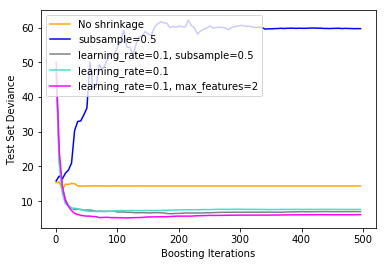

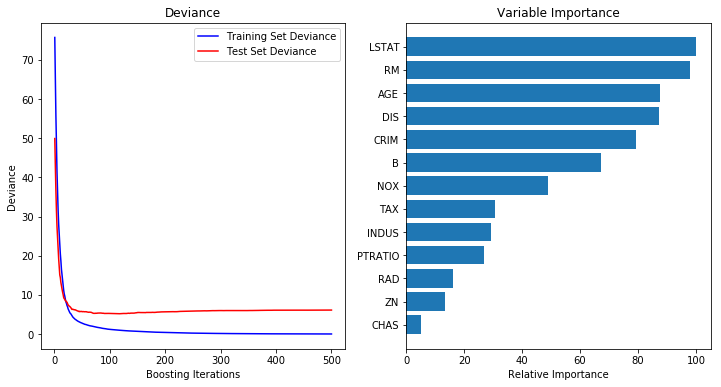

In [266]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Load data
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# #############################################################################
# Fit regression model
original_params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

clf = ensemble.GradientBoostingRegressor(**original_params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# gbm regularzation - 1) subsampling
#                   - 2) shrinkage
#                   - 3) early stopping
for label, color, setting in  [('No shrinkage', 'orange',
                               {'learning_rate': 1.0, 'subsample': 1.0}),
                              ('subsample=0.5', 'blue',
                               {'learning_rate': 1.0, 'subsample': 0.5}),
                              ('learning_rate=0.1, subsample=0.5', 'gray',
                               {'learning_rate': 0.1, 'subsample': 0.5}),
                               ('learning_rate=0.1', 'turquoise',
                               {'learning_rate': 0.1, 'subsample': 1.0}),
                              ('learning_rate=0.1, max_features=2', 'magenta',
                               {'learning_rate': 0.1, 'max_features': 2})]:
    params = dict(original_params)
    params.update(setting)
    clf = ensemble.GradientBoostingRegressor(**params)
    clf.fit(X_train, y_train)
    test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_predict(X_test)):
        test_score[i] = clf.loss_(y_test, y_pred)
#         print("test_score: ", test_score[i])
    plt.plot((np.arange(test_score.shape[0]) + 1)[::5], test_score[::5],
             '-', color=color, label=label)

plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')

plt.show()

# compute test set deviance
# Plot training deviance
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(original_params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(original_params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()